In [33]:
from tqdm import tqdm   # you may have to download it
import hashing_lib as hl
import time
import numpy as np
import re
import string
import random
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# In hashing_lib.py we imported BitVector, you may have to download it

# 1. Hashing task!

We found the optimal number of hash functions $ k $, for a given size of the bloom filter $ m $ and number of elements $ n $, approximating $ k = \frac{m}{n}ln2 $.

We set $ p $ as the desired false positive probability and found that $ k = -\log_2{p} $ is a good approximation.

So setting $ p = 0.01 $ we have $ k = 6.64 \simeq 6 $

We found that in $ passwords1.txt $ there are $ 100\,000\,000 $ passwords so $ n = 100\,000\,000$.

Now we can set the size $ m $ of the $ BloomFilter $, $ m = -\frac{n\ln{p}}{\ln^2{2}} \simeq 958\,505\,837 $

In [2]:
p = 0.01
n = 100_000_000
# we choose 958_505_837
m = 958_505_837
# number of hashing functions: k = 6
k = 6

We choose to create a Class $ BloomFilter $ that take in input $ m $ and $ k $ precalculated. The class create a bit vector of size $ m $ and keep records of the number of passwords added in the filter and the number of probable duplicates found.

In $ Less Hashing, Same Performance: Building a Better Bloom Filter $ we found a theorem that say we don't have to create 6 hashing functions (that are computational expensive), but instead we can use 2 independent hashing functions, $ h_1 $ and $ h_2 $ and iterate them using the following formula: $$ g_i(x) = h_1(x) + ih_2(x) + f(i) \mod{m} $$
with $ i $ in $ range(k) $.

In our case we defined 2 simple hashing functions $ hash\_1(string) $ and $ hash\_2(string) $ and choose $ f(i) = i^2 $.

In [3]:
bloom_filter = hl.BloomFilter(m, k)

In [4]:
# 100,000,000 passwords in file1
s = time.time()

with tqdm(total = n) as pbar:
    with open("../data/passwords1.txt") as fin:
        for line in fin:
            line = line.strip()
            bloom_filter.add_to_bloom(line)
            pbar.update(1)
            
# 39,000,000 passwords in file1
with open("../data/passwords2.txt") as fin2:
    with tqdm(total = 39_000_000) as pbar:
        for line in fin2:
            line = line.strip()
            bloom_filter.check_in_bloom(line)
            
            pbar.update(1)

print('Execution time: ', (time.time() - s)/60, 'minutes')

100%|██████████| 39000000/39000000 [13:30<00:00, 48141.68it/s]

Execution time:  68.74856994549434 minutes


In [5]:
# print some stats of the bloom filter
bloom_filter.print_stats()
print('False positives probability :', p*100, '%')

Number of elements:  100000000
Number of probably duplicates:  14253875
Size of the filter:  958505837
Number of hashing functions:  6
False positives probability : 1.0 %


## Bonus

We create a set of passwords to see the number of actual duplicates.

We use the set cause it doesn't allow duplicates, so knowing the number of total passwords we can calculate the number of duplicates

##### This task is really heavy, if you want to see only the actual duplicates just run the last line
We found out that the number of actual duplicates is $ 14\,000\,000 $, so we can use this and substract to the probably duplicates of the filter to find the real false positives.

In [10]:
all_passwords = set([])
with tqdm(total = n) as pbar:
    with open("passwords1.txt") as fin:
        for line in fin:
            # add pass to set
            all_passwords.update([line.strip()])
            pbar.update(1)
            
with open("passwords2.txt") as fin2:
    with tqdm(total = 39_000_000) as pbar2:
        for line in fin2:
            # add pass to set
            all_passwords.update([line.strip()])
            pbar2.update(1)


100%|██████████| 39000000/39000000 [00:59<00:00, 657872.79it/s]


In [12]:
# Calculate actuall duplicates
actual_duplicates = 139_000_000 - len(all_passwords)

In [13]:
print(actual_duplicates )

14000000


So the number of the false positives is:

In [6]:
bloom_filter.n_duplicates - 14_000_000

253875

### Conclusions
So out of $ 25\,000\,000 $ passwords only $ 253\,875 $ results as false positive.

We can state that our bloom filter with  $ 1\% $ false positive probability worked.

# 2. Alphabetical Sort

## Part 1

### Build your own implementation of Counting Sort

In [1]:
def CountingSort_num(A):
    size = max(A)  
    aux = np.zeros(size+1, dtype=int) # we define an auxiliary array 
    for i in A:
        aux[i] += 1    # with this for we can see the occurrency of each element to the respective index
    sort = []   # defining the output
    for j in range(size+1):
        sort.extend([j]*aux[j])
    return sort

##### Testing (Comparing sorted() function with our CountingSort function)

In [4]:
test = [3, 1, 4, 2, 6, 8, 9, 2, 5]

print(sorted(test))
print(CountingSort_num(test))

[1, 2, 2, 3, 4, 5, 6, 8, 9]
[1, 2, 2, 3, 4, 5, 6, 8, 9]


In [5]:
# just to be sure

sorted(test)==CountingSort_num(test)

True

#### Time Complexity

Theoretically time complexity for: CountingSort_num():

There are 2 "for" cycle that are scanning through n (size of the maximum number in the list), so the complexity is:

O(2n) → O(n)


## Part 2

### Build an algorithm, based on your implementation of Counting Sort, that receives in input a list with all the letters of the alphabet (not in alphabetical order), and returns the list ordered according to alphabetical order. Discuss time complexity (theoretically and empirically).

#### First of all we create a list containing all the letters of the alphabet not in alphabetical order.

In [7]:
alphabet_l = string.ascii_lowercase
alphabet_u = string.ascii_uppercase

In [8]:
# we use "sample" function to get elements without replacement
string_letters = random.sample(alphabet_l + alphabet_u, k=52)

#### Now, given this list, we implement our CountingSort function to get the ordered list of letters.

In [22]:
def CountingSort_let(letters):
    
    alphabet_l = string.ascii_lowercase
    alphabet_u = string.ascii_uppercase
    
    # first thing: for each letter we get the Unicode values

    unicode_l = []
    unicode_u = []

    for i in alphabet_l:
        unicode_l.append(ord(i))
    for j in alphabet_u:
        unicode_u.append(ord(j))

    # now we create a map to get in order the Unicode values associated to upper and lower case (example: AaBbCc...).
    # in this way we are initializing the alphabetical order.

    unicode_map = []

    for p in zip(unicode_u, unicode_l):
        for code in p:
            unicode_map.append(code)

    # creating a dictionary to have an index for each unicode

    dict_alpha = {code:i for i, code in enumerate(unicode_map)}

    # creating the reverse of the dictionary

    dict_alpha_rev = {ind:code for code, ind in dict_alpha.items()}

    # we define an auxiliary array

    aux = np.zeros(len(dict_alpha), dtype=int)

    # taking the input, we have to convert it into Unicode values

    num = []
    for i in letters:
        num.append(ord(i))

    # Now, as we made for the CountingSort function for the numbers,
    # we check the occurrences of each character (from the input)
    # and we set values of aux

    for i in num:
        aux[dict_alpha[i]] += 1

    sorted_letters = []

    for i in range(len(aux)):
        sorted_letters.extend([chr(dict_alpha_rev[i])]*aux[i])

    return sorted_letters

#### Now we can finally test our CountingSort with the dictionary containing all the letters of the alphabet not in order.

In [17]:
print(string_letters)

['j', 'Z', 'f', 'a', 'X', 'o', 'g', 'r', 'i', 'R', 'h', 'U', 'n', 'l', 'S', 'W', 'G', 'q', 't', 'k', 'P', 'F', 'b', 's', 'D', 'N', 'Q', 'y', 'O', 'E', 'Y', 'A', 'e', 'V', 'c', 'p', 'M', 'T', 'x', 'z', 'm', 'C', 'B', 'H', 'u', 'w', 'I', 'L', 'J', 'd', 'v', 'K']


In [23]:
# Applying the function
print(CountingSort_let(string_letters))

['A', 'a', 'B', 'b', 'C', 'c', 'D', 'd', 'E', 'e', 'F', 'f', 'G', 'g', 'H', 'h', 'I', 'i', 'J', 'j', 'K', 'k', 'L', 'l', 'M', 'm', 'N', 'n', 'O', 'o', 'P', 'p', 'Q', 'q', 'R', 'r', 'S', 's', 'T', 't', 'U', 'u', 'V', 'v', 'W', 'w', 'X', 'x', 'Y', 'y', 'Z', 'z']


#### Time complexity

We can not take into consideration the time complexity of creating the lists containing the ASCII value of upper and lower cases cause the for loops have a constant number of iteration, in our case 26 for the lower case and 26 for the upper case.

We can say the same for the alphabet dictionary.

The given N = len(letters):
* The first loop take O(N)
* The second also take O(N)
* The last loop take O(52)

So the time complexity of this functions is: $ O(2N + 52) \rightarrow O(N) $

## Part 3

### Build an algorithm, based on your implementation of Counting Sort, that receives in input a list of length m, that contains words with maximum length equal to n, and returns the list ordered according to alphabetical order. Discuss time complexity (theoretically and empirically).

In [19]:
def CountingSort_wor(words):
    output = list()
    m = len(words)
    
    for i in range(m): 
        if i == 0: # start comparing words appending first word
            output.append(words[i])
        else:
            # checking and sorting words 
            for k in range(len(output)):
                j = 0
                # looking for the first 2 different letters
                while j < len(words[i])-1 and j < len(output[k])-1 and words[i][j] == output[k][j]:
                    j += 1
                
                # all strings are ordered according to their first word
                if output[k][j] == ' ' and words[i][j] != ' ':
                    new_out = [output[k], words[i]]
                    if k == len(output)-1:
                        output.append(words[i])
                        break           
      
                elif output[k][j] != ' ' and words[i][j] == ' ':
                    new_out = [words[i], output[k]]
                    output.insert(k, words[i])
                    break

                elif j != len(output[k])-1 and j == len(words[i])-1 and words[i][j] == output[k][j]:
                    new_out = [words[i], output[k]]
                    output.insert(k, words[i])
                    break                
                
                # priority to short words
                elif j == len(output[k])-1 and j != len(words[i])-1 and words[i][j] == output[k][j]:
                    new_out = [output[k], words[i]] 
                    if k == len(output)-1:
                        output.append(words[i])
                        break           

                # sorting the single letters
                else:
                    x = [words[i][j], output[k][j]]
                    new_out = CountingSort_let(x) # recalling function for sorting letters
                    
                    if new_out == x:
                        output.insert(k, words[i])
                        break
                    else:
                        if k == len(output)-1:
                            output.append(words[i])
                            break                

    return output

#### Test our function

In [20]:
s = 'Given a set of words, a common natural task is the one of sorting them in alphabetical order. It is something that you have for sure already done once in your life, using your own algorithm without maybe knowing it.'
test = s.split()

In [27]:
print(CountingSort_wor(test))

['a', 'a', 'algorithm', 'alphabetical', 'already', 'common', 'done', 'for', 'Given', 'have', 'It', 'in', 'in', 'is', 'is', 'it.', 'knowing', 'life,', 'maybe', 'natural', 'of', 'of', 'once', 'one', 'order.', 'own', 'set', 'something', 'sorting', 'sure', 'task', 'that', 'the', 'them', 'using', 'without', 'words,', 'you', 'your', 'your']


#### Time complexity

We take a word from our initial list and append it a output list in the right place. So we have to compare every word in input list with every word in output list, so we will have a double for loop.

Given $M$ = len(words), the number of words to sort and $N$ = len(words[i]) the max length of words:
* The first loop take O(M)
* The second loop, iside the first, take O(M)
* The while loop, inside the second, take O(N)

For the asymptotic analysis we can not take into consideration the time complexity of the if/else statement.

So we have a 3 loops inside each other: $ O(M*M*(N + 1 + ....) \rightarrow O(M^2*N) $

This is thw worst case, in fact if $ M >>> N :  O(M^2*N) \rightarrow O(M^2) $

# 3. Find similar wines!

# 4. K-means can go wrong!

K-means is a good algorithm for local fine-tuning but it has serious limitation to relocate the centroids when the clusters do not overlap, so a better initialization can compensate for the weakness of k-means.

Any clustering algorithm could be used as an initialization technique for k-means. However, solving the location of initial centroids is not significantly easier than the original clustering problem itself, so our initialization algorithm must have a lower (or equal) time complexity than k-means.

In this exercise we try and compute the running time of clustering with k-means and then with k-means++.

So to see if a better initialization works, we use k-means++ to choose the initial values (or seeds) for the k-means clustering algorithm.


##### We import the dataframe used in the lab (crimes is Chicago), and test k-means and k-means++ on the same data

In [31]:
# Import chicago crimes dataset and clean the data
# We select only the longitude e Latitude
df = pd.read_csv("../crimes.csv", usecols = ['Longitude', 'Latitude'])
# clean data
df = df.dropna(0)
df.drop( df[ df['Longitude'] < -91].index , inplace=True)

In [32]:
df.head(5) # Some values of the dataset

,Latitude,Longitude
63366,41.708589,-87.612583
63450,41.884865,-87.755230
63451,41.940298,-87.732066
63527,41.697609,-87.613508
63934,41.729973,-87.653167


#### Running time of k-means with random init

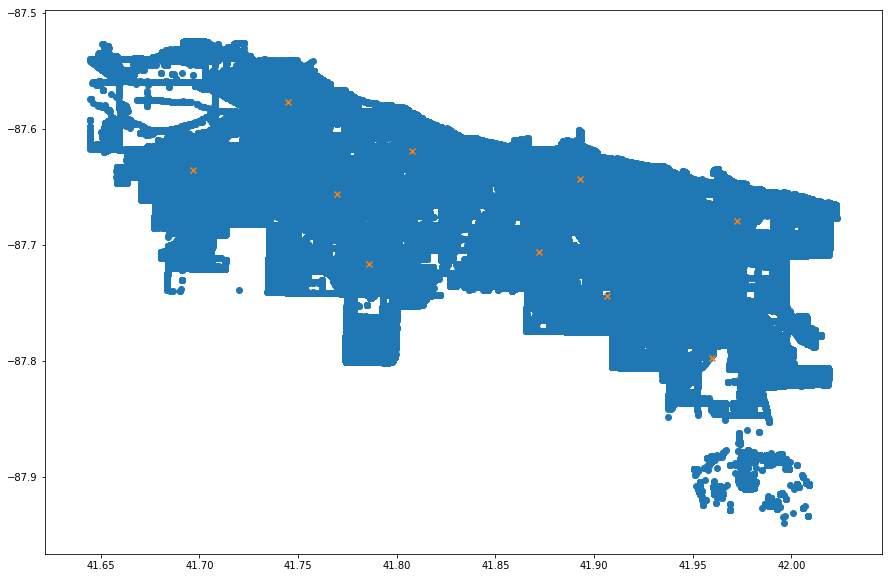

Rand time:  483.0710108280182


In [34]:
s = time.time()

# Create our k-mean model with random init
model = KMeans(n_clusters = 10, init = 'random')

# Fit our data in the model
model.fit(df[['Latitude', 'Longitude']])

centroids = model.cluster_centers_

fig = plt.figure(figsize = (15,10))
plt.scatter(df['Latitude'],df['Longitude'])
plt.scatter(centroids[:,0], centroids[:,1], marker='x')

plt.show()


time_rand = time.time() - s
print('Rand time: ', time_rand)

#### Running time of k-means++

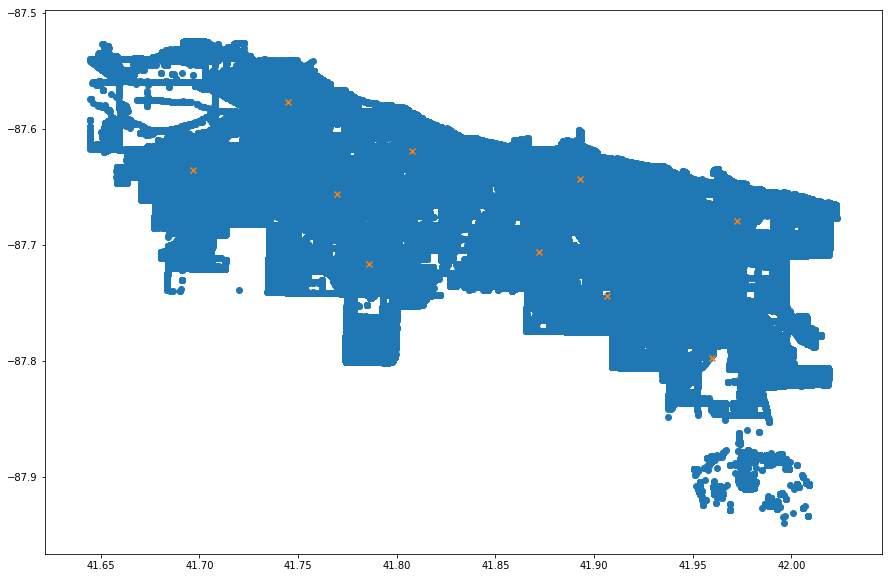

K-means++ time:  382.7605662345886


In [35]:
t = time.time()

# Create our k-mean model with k-means++ init
model1 = KMeans(n_clusters = 10, init = 'k-means++')

# Fit our data in the model
model1.fit(df[['Latitude', 'Longitude']])

centroids1 = model.cluster_centers_

fig1 = plt.figure(figsize = (15,10))
plt.scatter(df['Latitude'],df['Longitude'])
plt.scatter(centroids1[:,0], centroids1[:,1], marker='x')
plt.show()

time_k = time.time() - t
print('K-means++ time: ', time_k)

So our speedup percentage is:

In [36]:
print(100*(1-time_k/time_rand), " %")

20.765155090033304  %


So we can conclude that using a better initialization can speedup the k-mean algorithm.